In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [6]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [7]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [8]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [9]:
res = rle2mask("5 4 11 1 13 1 16 4", *(5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Data Generators

#### Basic data generator

In [10]:
class SimpleImgDataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, *self.outcome_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            print(filename)
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA) # assumed resize to smaller
            X[idx,] = img
            
            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)          
            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = mask
            
        return X, y

In [ ]:
idx = int(0.8*len(df_train))

train_batches = SimpleImgDataGenerator(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(64, 400), batch_size = 2, n_channels=3, shuffle=False)

#valid_batches = SimpleImgDataGenerator(df_train.iloc[idx:], ...................

X, y = train_batches.__getitem__(17) 
print(X.shape)
print(y.shape)
print(X[0].shape)
print(y[0].shape)


In [ ]:
plt.figure(figsize=(20,4))

data = X[0]
print(data.dtype)
print(f'Data shape: {data.shape}')

if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data.astype(int))

plt.show()

In [ ]:
plt.figure(figsize=(20,4))

data = y[0]
print(f'Data shape: {data.shape}')

if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data.astype(int))

plt.show()

In [ ]:
df_train.loc[df_train['ImageId']=='01053d28f.jpg']['EncodedPixels'].values[0]

In [ ]:
plt.figure(figsize=(20,4))

img = cv2.imread( './input/severstal-steel-defect-detection/train_images/01053d28f.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = rle2mask(df_train.loc[df_train['ImageId']=='01053d28f.jpg']['EncodedPixels'].values[0], img.shape[0], img.shape[1])
img[mask==1,0] = 255
print(img.shape)
plt.imshow(img)

plt.show()

#### Preprocessing data generator

In [ ]:
# Data generator with preprocessing
class ImgDataGenerator_V0(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, 
                 img_normalize=False, img_center = False, img_standardize = False, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            print(filename)
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            
            if self.img_normalize:
                img = self.prep_normalize(img)
                print('Normalization')
            if self.img_center:
                img = self.prep_center(img)
                print('Centering')
            if self.img_standardize:
                img = self.prep_standardize(img)
                print('Standardization')
            
            orig_img_shape = img.shape[0:2]
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img
            
            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = mask
            
        return X, y
    
    
    def prep_normalize(self, img):
        img_norm = img.astype('float32')
        # normalize to range 0-1
        img_norm = img_norm / 255.0
        return img_norm

    
    def prep_center(self, img):
        img_cent = img.astype('float32')
        # calculate statistics
        m = img_cent.mean()
        # center datasets
        img_cent = img_cent - m
        return img_cent
    
    
    def prep_standardize(self, img):
        img_stan = img.astype('float32')
        m = img_stan.mean()
        s = img_stan.std()
        # center datasets
        img_stan = (img_stan - m) / s
        return img_stan
    

In [ ]:
idx = int(0.8*len(df_train))

train_batches = ImgDataGenerator_V0(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                 outcome_img_shape=(128, 800), batch_size = 4, n_channels=3, 
                                 img_normalize=False, img_center = True, img_standardize=False, shuffle=False)

#valid_batches = ImgDataGenerator_V0(df_train.iloc[idx:], ...................

X_0, y_0 = train_batches.__getitem__(0) 
print(X_0.shape)
print(y_0.shape)
print(X_0[0].shape)
print(y_0[0].shape)


In [ ]:
plt.figure(figsize=(20,4))

data = X_0[1]
print('Train', data.min(), data.max(), data.mean(), data.std())

print(data.dtype)
print(f'Data shape: {data.shape}')

if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data)

plt.show()

In [ ]:
plt.figure(figsize=(20,4))

data = y_0[1]
print(f'Data shape: {data.shape}')

if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data.astype(int))

plt.show()

In [ ]:
plt.figure(figsize=(20,4))

img = cv2.imread( './input/severstal-steel-defect-detection/train_images/0002cc93b.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = rle2mask(df_train.loc[df_train['ImageId']=='0002cc93b.jpg']['EncodedPixels'].values[0], img.shape[0], img.shape[1])
img[mask==1,0] = 255
print(img.shape)
plt.imshow(img)

plt.show()

#### Enhanced image preprocessing data generator

In [148]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V2(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, brightness_range=None, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, brightness_range=brightness_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')
        self.datagen_mask = ImageDataGenerator(shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            print(filename)
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = mask
         
        seed = 7
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_img.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        return zip(image_generator, mask_generator)#.__next__()
        

In [154]:
idx = int(0.8*len(df_train))

#dataGen = ImgDataGenerator_V1(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
dataGen = ImgDataGenerator_V2(df_train.iloc[:16], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(64, 400), batch_size = 8, n_channels=3, 
                                    img_normalize=False, img_center=False, img_standardize=True,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    brightness_range=[0.9,1.1],
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

#valid_batches = ImgDataGenerator_V1(df_train.iloc[idx:], ...................

dataGenIterator = dataGen.__getitem__(0)
#dataGenIterator = dataGen.__getitem__(0)
#img_tuple = dataGen.__getitem__(0)
print(type(img_tuple))
print(len(img_tuple))
print(img_tuple[0].shape)
print(len(img_tuple[0]))
print(img_tuple[1].shape)
print(len(img_tuple[1]))

0002cc93b.jpg
0007a71bf.jpg
000a4bcdd.jpg
000f6bf48.jpg
0014fce06.jpg
0025bde0c.jpg
0025bde0c.jpg
002af848d.jpg
<class 'tuple'>
2
(2, 64, 400, 3)
2
(2, 64, 400, 1)
2


In [150]:
#dataGenIterator = dataGenIterator.__next__()

print(len(img_tuple))
print(img_tuple[0].shape)
data = img_tuple[0][2]
print('Train', data.min(), data.max(), data.mean(), data.std())

plt.figure(figsize=(20,4))
print(data.dtype)
print(f'Data shape: {data.shape}')
if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data) #.astype(int)

plt.figure(figsize=(20,4))
data_mask = img_tuple[1][2]
print(f'Data shape: {data_mask.shape}')

if (data_mask.shape[2] == 1):
    plt.imshow(np.squeeze(data_mask, axis=2), cmap="gray")
else:
    plt.imshow(data_mask.astype(int))

plt.show()

2
(2, 64, 400, 3)


IndexError: index 2 is out of bounds for axis 0 with size 2

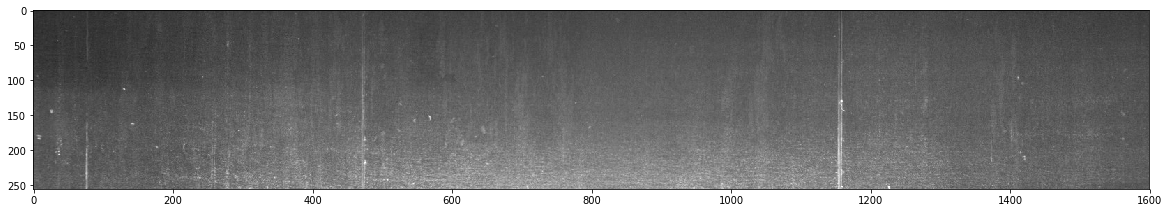

In [72]:
plt.figure(figsize=(20,4))

img = cv2.imread( './input/severstal-steel-defect-detection/train_images/0007a71bf.jpg')
plt.imshow(img)

plt.show()

(256, 1600, 3)


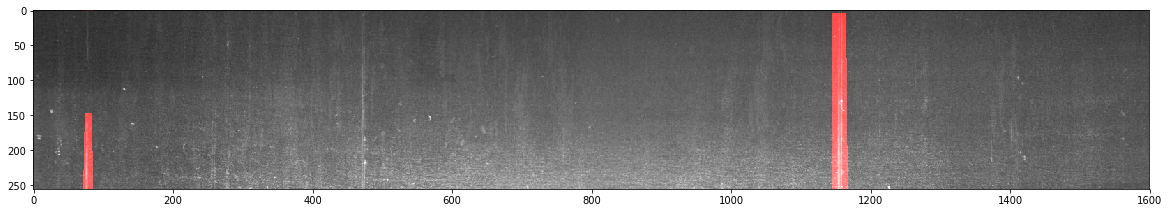

In [79]:
plt.figure(figsize=(20,4))

img = cv2.imread( './input/severstal-steel-defect-detection/train_images/0007a71bf.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = rle2mask(df_train.loc[df_train['ImageId']=='0007a71bf.jpg']['EncodedPixels'].values[0], img.shape[0], img.shape[1])
img[mask==1,0] = 255
print(img.shape)
plt.imshow(img)

plt.show()